A key application for quantum computers is the simulation of quantum systems. This tutorial demonstrates a CUDA-Q implementation of a Suzuki-Trotter simulation of a Heisenberg Model Hamiltonian to compute the magnetization of a spin chain.

This example leverages CUDA-Q’s state handling capabilities to perform recursive Trotter simulations.

In [2]:
import cudaq
import time
import numpy as np
from typing import List

The goal of this problem is to estimate the time evolution of an initial quantum state governed by a Hamiltonian and compute the average magnetization of the final state. The time evolution is approximated using the Trotter method:

The Heisenberg Hamiltonian is defined below, parameterized by these predefined constants: \(J_x\), \(J_y\), \(J_z\), and \(h\). The time step \(\Delta t\) is selected for this problem, along with \(n\_steps\) and \(n\_spins\) (\(n\_spins = 11\), \(n\_steps = 10\)), determining the size of the simulation. The default setup considers 11 spins and 10 steps, which can easily be simulated on a CPU. If you have access to at least one GPU, the problem can be increased to around 25 spins and 100 time steps.

In [3]:
g = 1.0
Jx = 1.0
Jy = 1.0
Jz = g
dt = 0.05
n_steps = 10
n_spins = 11
omega = 2 * np.pi


def heisenbergModelHam(t: float) -> cudaq.SpinOperator:
    tdOp = cudaq.SpinOperator(num_qubits=n_spins)
    for i in range(0, n_spins - 1):
        tdOp += (Jx * cudaq.spin.x(i) * cudaq.spin.x(i + 1))
        tdOp += (Jy * cudaq.spin.y(i) * cudaq.spin.y(i + 1))
        tdOp += (Jz * cudaq.spin.z(i) * cudaq.spin.z(i + 1))
    for i in range(0, n_spins):
        tdOp += (np.cos(omega * t) * cudaq.spin.x(i))
    return tdOp

In [4]:
@cudaq.kernel
def getInitState(numSpins: int):
    q = cudaq.qvector(numSpins)
    for qId in range(0, numSpins, 2):
        x(q[qId])

"""
Performs a single Trotter step given an initial state and returns the resulting state.

Notes:
1. Utilizes CUDA-Q’s state handling capabilities, allowing each step to proceed from the previous state still stored in GPU memory during the simulation. This results in a significant speedup, as demonstrated in the plot at the end of this tutorial.
2. Leverages the pauli_word object, which allows a list of Pauli words and their coefficients to be passed into the kernel and applied as an exponentiated matrix operation using exp_pauli.
"""

In [5]:
@cudaq.kernel
def trotter(state: cudaq.State, coefficients: List[complex],
            words: List[cudaq.pauli_word], dt: float):
    q = cudaq.qvector(state)
    for i in range(len(coefficients)):
        exp_pauli(coefficients[i].real * dt, q, words[i])

The functions below are used to strip the Hamiltonian spin operator into a list of coefficients and Pauli words.

In [6]:
def termCoefficients(op: cudaq.SpinOperator) -> List[complex]:
    result = []
    ham.for_each_term(lambda term: result.append(term.get_coefficient()))
    return result


def termWords(op: cudaq.SpinOperator) -> List[str]:
    result = []
    ham.for_each_term(lambda term: result.append(term.to_string(False)))
    return result

Finally, a second spin operator is defined to compute the expectation value corresponding to the average magnetization.

In [7]:
average_magnetization = cudaq.SpinOperator(num_qubits=n_spins)
for i in range(0, n_spins):
    average_magnetization += ((1.0 / n_spins) * cudaq.spin.z(i))
average_magnetization -= 1.0

### Running the Simulation

Before looping through the Trotter steps, the initial state is constructed.

In [8]:
state = cudaq.get_state(getInitState, n_spins)

Next, we loop through the time steps. At each step, we define the time-dependent Hamiltonian. This Hamiltonian is used to construct the Trotter kernel for that time step, which is then used to compute the average magnetization expectation value. The state is saved and used as the initial state for the subsequent time step.

In [9]:
results = []
times = []
for i in range(0, n_steps):
    start_time = time.time()
    ham = heisenbergModelHam(i * dt)
    coefficients = termCoefficients(ham)
    words = termWords(ham)
    magnetization_exp_val = cudaq.observe(trotter, average_magnetization, state,
                                          coefficients, words, dt)
    result = magnetization_exp_val.expectation()
    results.append(result)
    state = cudaq.get_state(trotter, state, coefficients, words, dt)
    stepTime = time.time() - start_time
    times.append(stepTime)
    print(f"Step {i}: time [s]: {stepTime}, result: {result}")

print(f"Step times: {times}")
print(f"Results: {results}")

Step 0: time [s]: 0.0375676155090332, result: -0.09042024163828166
Step 1: time [s]: 0.002967357635498047, result: -0.08898564687193886
Step 2: time [s]: 0.003292083740234375, result: -0.08698024360923415
Step 3: time [s]: 0.003481626510620117, result: -0.08507694741170907
Step 4: time [s]: 0.0036933422088623047, result: -0.08394118068746997
Step 5: time [s]: 0.003942966461181641, result: -0.08394076573115139
Step 6: time [s]: 0.00487065315246582, result: -0.08502222139504187
Step 7: time [s]: 0.0049800872802734375, result: -0.08677832064885871
Step 8: time [s]: 0.003471851348876953, result: -0.08863390649349775
Step 9: time [s]: 0.003048419952392578, result: -0.09005513983609514
Step times: [0.0375676155090332, 0.002967357635498047, 0.003292083740234375, 0.003481626510620117, 0.0036933422088623047, 0.003942966461181641, 0.00487065315246582, 0.0049800872802734375, 0.003471851348876953, 0.003048419952392578]
Results: [-0.09042024163828166, -0.08898564687193886, -0.08698024360923415, -0.

CUDA-Q’s state handling capabilities significantly enhance the performance of this algorithm. By storing the previous state in GPU memory, the simulation can proceed without resimulating all prior operations at each time step. This approach reduces the number of operations required, resulting in a substantial performance boost. The figure below illustrates a 24X speedup achieved by a 100-step Trotter simulation.

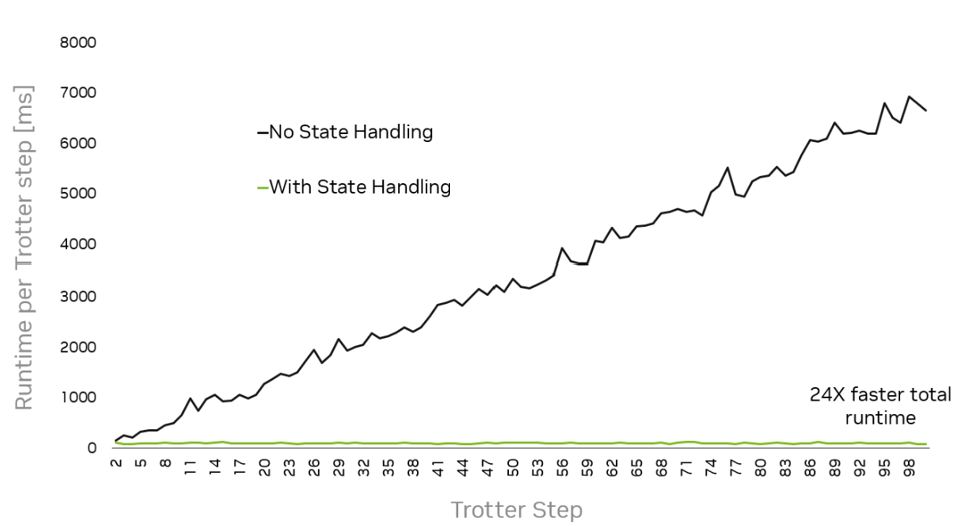